<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Boroujerdi/Boroujerdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [2]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [3]:
!nvidia-smi

Wed Jun 24 20:21:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip -q install transformers

In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [6]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'

In [7]:
enc_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
dec_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-4_H-128_A-2')

In [8]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        self.dialogues.dropna(inplace=True)
        
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)
        
        s = self.dialogues['response'].apply(dec_tokenizer.encode).apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove)
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [9]:
train_dataset = MyDataset(train_file, max_len=128)
valid_dataset = MyDataset(valid_file, max_len=510)
print(len(train_dataset))
print(len(valid_dataset))

41489
4458


In [10]:
enc_tokenizer.decode(train_dataset[399]['input_pair'])
#dec_tokenizer.decode(train_dataset[399]['response'])

'[CLS] yoga [SEP] no _ passages _ used [SEP]'

In [11]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 6])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 7])
****
649
70


In [45]:
o = torch.rand(8,5)
o

tensor([[0.7971, 0.5570, 0.6176, 0.8620, 0.0346],
        [0.2617, 0.9808, 0.7682, 0.6243, 0.2782],
        [0.4833, 0.6336, 0.0463, 0.0938, 0.4098],
        [0.9999, 0.7067, 0.1404, 0.7106, 0.1492],
        [0.0357, 0.5070, 0.1811, 0.8164, 0.6623],
        [0.6191, 0.1194, 0.4503, 0.9537, 0.8837],
        [0.2407, 0.3513, 0.4584, 0.2995, 0.2904],
        [0.1673, 0.0891, 0.2090, 0.0751, 0.6567]])

In [51]:
y = torch.LongTensor(8).random_(0,5)
y

tensor([2, 0, 0, 0, 4, 1, 4, 2])

In [61]:
o[y!=2]

tensor([[0.2617, 0.9808, 0.7682, 0.6243, 0.2782],
        [0.4833, 0.6336, 0.0463, 0.0938, 0.4098],
        [0.9999, 0.7067, 0.1404, 0.7106, 0.1492],
        [0.0357, 0.5070, 0.1811, 0.8164, 0.6623],
        [0.6191, 0.1194, 0.4503, 0.9537, 0.8837],
        [0.2407, 0.3513, 0.4584, 0.2995, 0.2904]])

In [72]:
z = torch.LongTensor(o[y!=2].shape[0]).fill_(2)
z

tensor([2, 2, 2, 2, 2, 2])

In [ ]:
torch.

In [73]:
-1*F.nll_loss(nn.functional.log_softmax(o[y!=2]), z, reduction='mean')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(-1.7754)

# Model

In [ ]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-4_H-128_A-2')
    
    # for p in self.seq2seq.encoder.embeddings.parameters():
    #   p.requires_grad = False
    
    # for p in self.seq2seq.decoder.bert.embeddings.parameters():
    #   p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, temperature, T=True):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    if T == True:
      kwargs = {'token_type_ids':segments_tensors}
    else:
      kwargs = {}
    generated = model.seq2seq.generate(encoder_input, decoder_start_token_id=101,
                                       num_beams=32,
                                       temperature=temperature,
                                       eos_token_id=102, ## [SEP] = 102
                                       num_return_sequences=16,
                                       **kwargs) ## [CLS] = 101
    #### generated = [1, len]
    return generated

In [ ]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

9480890


#Optimizer



In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        return 1e-5
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

In [ ]:
optimizer2 = NoamOpt(128, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optimizer = NoamOpt(128, 1, 1000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

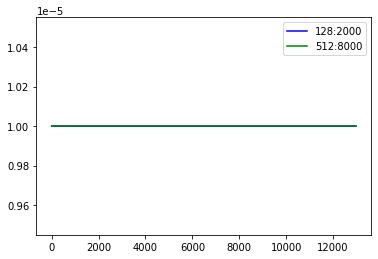

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, 20*649), [optimizer.rate(i) for i in range(1, 20*649)], color='blue')
plt.plot(np.arange(1, 20*649), [optimizer2.rate(i) for i in range(1, 20*649)], color='green')
plt.legend(["128:2000", "512:8000", "256:4000"])

In [ ]:
print("Maximum learning rate is:",max([optimizer.rate(i) for i in range(1, 20*649)]))

Maximum learning rate is: 1e-05


In [ ]:
optimizer.rate(20000)

1e-05

In [ ]:
print("Peak step is:",max(enumerate([optimizer.rate(i) for i in range(1, 20*649)]), key=lambda x: x[1])[0])

Peak step is: 0


# Training

In [ ]:
import torch.nn

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  # cold
  #T = 1
  #model_output = model_output / T

  if 'easy_training' in kwargs:
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)
  return loss

In [ ]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  #kwargs = {'easy_training':4}
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader)):
    total_loss += valid_step(batch_idx, batch)
  print("temperature is 1:")
  valid_inference(temperature=1)
  print("temperature is 0.33:")
  valid_inference(temperature=0.33)
  print("temperature is 2:")
  valid_inference(temperature=2)
  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=313, temperature=1):
  hk_pair =  train_dataset[idx]['input_pair'].to(dev)
  hk_segment = train_dataset[idx]['input_pair_segments'].to(dev)
  response = train_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, temperature, T=False)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [ ]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Boroujerdi/"
  step = 0
  log_list = []

In [ ]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Boroujerdi"
checkpoint = torch.load(model_dir+'/boroujerdi_10000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

10000


In [ ]:
from tqdm.auto import tqdm

MAX_STEP = 20000
STEP_SAVE = 1000
STEP_CHECK = 1000
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader)):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict()
            }, model_dir+'boroujerdi_{}steps.model'.format(step_num))
    step_num += 1

1


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm sure sure. i'm sure sure. i
model says:  [CLS] i'm sure sure. i'm sure sure. i'm sure sure. i
model says:  [CLS] i'm not sure. i'm not sure. i'm sure sure. i
model says:  [CLS] i'm sure sure. i'm not sure. i'm sure sure. i
model says:  [CLS] i'm not sure. i'm sure sure, i'm sure sure. i
model says:  [CLS] i'm n

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i love a favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite
model says:  [CLS] i love my favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite
mode

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i don't know. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i don't know it. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i love a lot of my favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite favorite
model says:  [CLS] i love a lot of the world. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love a lot of the best favorite favorite favorite favorite fa

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. it's a lot of
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS] i'm not

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i think it's a lot
model says:  [CLS] i lo

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sur

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i love a lot of money. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, i love a lot of money. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love a lot of a lot of money. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love to get a lot of money. [SEP] [SEP] [SEP] [SEP] [SEP

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS] i'm not sure, i'm not sure, but i'm not sure.
model says:  [CLS] i'm not

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS] i lo

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure, but i'm

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i love a lot of money. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love a lot of money. i love a lot of money. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love a lot of money. i have a lot of money. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, i love a lot of money. [SEP] [SEP] [SEP

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure. i'm not sure. i think i'm not sure
model says:  [CLS] i

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS] i'm not sure. i'm not sure. [SEP] [SEP] [SEP] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, i love to make it a lot of money. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love the best selling fashion designer. i love the best selling fashion. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. i think it's a lot of money. [SEP] [SEP] [SEP]
model says:  [CLS] i love the best selling fashion.

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS] i'm 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, i'm not sure. i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, i'm not sure. i think it's a lot of money. [SEP]
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. [SEP]
model says:  [CLS] yes, she was a fashion designer. she was a fashion designer. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure,
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure,
model says:  [CLS] i'm 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure, but i don't think
model says:  [

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, i'm not sure. i think it's a lot of money. [SEP]
model says:  [CLS] yes, she was a fashion designer. she was a fashion designer. she was a fashion designer
model says:  [CLS] i'm not sure, but i think it's a lot of the fashion. [SEP]
model says:  [CLS] i'm not sure. i think it's a lot of the fashion. [SEP] [SEP]
model says:

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure,
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure,
model says:  [CLS] i'

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, i think it was a fashion designer. it was a fashion designer. it was a
model says:  [CLS] i think it was a fashion designer. it was a fashion designer. it was a fashion designer
model says:  [CLS] yes, it was a fashion designer. it was a fashion designer. it was a fashion designer
model says:  [CLS] i'm not sure. i think it

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, she was a fashion designer. she was a fashion designer. she was a fashion designer
model says:  [CLS] yes, i'm not sure. i'm not sure. i think it's
model says:  [CLS] yes, i'm not sure. i think it's a lot of the fashion.
model says:  [CLS] yes, i'm not sure. i'm not sure. i'm not sure
model says:  [CLS] yes, she was a fashi

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] yes, i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SE

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, she was a fashion designer. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, i love the fashion designer. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, she was a designer. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love the fashion designer. [SEP] [SEP] [SEP] [S

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure, but i'm not sure. i think it's a
model says:  [CLS] yes, i'm not sure. i'm not sure. i'm not sure
model says:  [CLS] i'm no

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i'm

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, she was a fashion designer. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, i think it was a fashion designer. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, she was a fashion designer. she was a fashion designer. [SEP]
model says:  [CLS] yes, i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure, but
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. i think it's a
model says:  [CLS] yes

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure, but i'm not sure. i'm not su

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] yes, she was a fashion designer. she was a fashion designer. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] yes, she was a fashion designer. she was a designer. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] she was a fashion designer. she was a fashion designer. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i don't know
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure,
model says:  [CLS]

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] " coco " chanel was a french fashion designer and businesswoman. [SEP] cool. did coco make clothing for women? dogs? men? who was her target audience? [SEP] chanel extended her influence beyond couture clothing, realising her design aesthetic in jewellery, handbags, and fragrance. [SEP] how much does her handbags cost? [SEP] you can google that. the only fashion designer listed on " time " magazine's. [SEP] fair enough! and that is very interesting. i didn't know that about time. when did coco chanel come out with her designs? [SEP] 5, has become an iconic product. [SEP]
response is:  [CLS] her iconic product is number 5 [SEP]
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure. i'm not sure. i'm not sure. i
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure,
model says:  [CLS] yes,

In [ ]:
valid_inference(idx=202, temperature=1e5)

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] swimming [SEP] swimming is when you propel yourself through water [SEP] i know, i love swimming but i wish i was faster. [SEP] swimming is fun for sports and recreational [SEP] it seems great for exercise too. [SEP] it can even be for exercise or survival if needed [SEP] it was probably better for survival a while ago haha. [SEP] its when you have coordinated movement of the limbs, the body, or both. [SEP] hmm that's an interesting way to put it. [SEP] no _ passages _ used [SEP]
response is:  [CLS] swimming can be very fun [SEP]
model says:  [CLS] i'm not sure, i don't know that it's great. i '
model says:  [CLS] i'm not sure, i don't know that it's great. i think
model says:  [CLS] i'm not sure, i don't know that it's great. i have
model says:  [CLS] i'm not sure, i don't know that it's okay. i think
model says:  [CLS] i'm not sure, i don't know that it's great, but i
model says:  [CLS] i'm not sure, i don't know that it's okay. i have
model says:  [CLS] i'm not sure, 

In [ ]:
log_list

[{'step': 1, 'train_loss': 14.16185474395752},
 {'step': 2, 'train_loss': 10.588570594787598},
 {'step': 3, 'train_loss': 8.754494667053223},
 {'step': 4, 'train_loss': 7.626872539520264},
 {'step': 5, 'train_loss': 7.459188938140869},
 {'step': 6, 'train_loss': 7.165883541107178},
 {'step': 7, 'train_loss': 6.705699443817139},
 {'step': 8, 'train_loss': 6.861814022064209},
 {'step': 9, 'train_loss': 7.119411945343018},
 {'step': 10, 'train_loss': 6.74100923538208},
 {'step': 11, 'train_loss': 6.516302108764648},
 {'step': 12, 'train_loss': 6.39729642868042},
 {'step': 13, 'train_loss': 6.507824420928955},
 {'step': 14, 'train_loss': 6.552713394165039},
 {'step': 15, 'train_loss': 6.616140842437744},
 {'step': 16, 'train_loss': 6.452396392822266},
 {'step': 17, 'train_loss': 6.47140645980835},
 {'step': 18, 'train_loss': 6.4972028732299805},
 {'step': 19, 'train_loss': 6.039199352264404},
 {'step': 20, 'train_loss': 6.292985439300537},
 {'step': 21, 'train_loss': 6.300108432769775},
 {

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)
output.backward()

tensor(1.5508, grad_fn=<NllLossBackward>)
